In [1]:
import os
import glob as glob
import timecorr as tc
import hypertools as hyp
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.spatial.distance import pdist, cdist, squareform
from sklearn.decomposition import PCA, IncrementalPCA
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  
import timecorr as tc
from timecorr.helpers import isfc, wisfc, mean_combine, corrmean_combine
import supereeg as se

In [2]:
def rbf(centers, widths, locs):
    """
    Radial basis function
    Parameters
    ----------
    centers : ndarray
        rbf coordinates (one row per RBF)
    widths : ndarray
        RBF radii
    locs : ndarray
        locations to evaluate the RBFs (one row per location)
        
    Returns
    ----------
    results : ndarray
        Matrix of RBF weights for each RBF (row), at each location (column)
    """    
    weights = np.exp(np.divide(-cdist(locs, centers, metric='euclidean') ** 2, np.tile(np.array(widths, ndmin=2), [locs.shape[0], 1])))
    return weights.T

In [3]:
def largest_indices(ary, n):
    """Returns the n largest indices from a numpy array."""
    flat = ary.flatten()
    indices = np.argpartition(flat, -n)[-n:]
    indices = indices[np.argsort(-flat[indices])]
    return np.unravel_index(indices, ary.shape)

In [4]:
def reduce_list(x, model):
    split = np.cumsum([len(xi) for xi in x])[:-1]
    x_r = np.vsplit(model.fit_transform(np.vstack(x)), split)
    if len(x) > 1:
        return [xi for xi in x_r]
    else:
        return [x_r[0]]

In [5]:
datadir = os.path.join(os.getenv('HOME'), 'Desktop', 'pca_env', 'pca_paper', 'pieman', 'data')


In [6]:
figdir = '../figs'
if not os.path.exists(figdir):
    os.mkdir(figdir)

In [7]:
nii_bo_dir = '../../data/niis'

In [8]:
pca_nii_bo_dir = os.path.join(nii_bo_dir, 'pcas')
if not os.path.exists(pca_nii_bo_dir):
    os.makedirs(pca_nii_bo_dir)

In [9]:
neurosynth_dir ='../figs/neurosynth_data/'
if not os.path.exists(neurosynth_dir):
    os.mkdir(neurosynth_dir)

In [10]:
n_f_dir = os.path.join(neurosynth_dir, 'figs')
if not os.path.exists(n_f_dir):
    os.mkdir(n_f_dir)
nii_dir = os.path.join(neurosynth_dir, 'niis')
if not os.path.exists(nii_dir):
    os.mkdir(nii_dir)
txt_dir = os.path.join(neurosynth_dir, 'txts')
if not os.path.exists(txt_dir):
    os.mkdir(txt_dir)
p_txt_dir = os.path.join(txt_dir, 'parsed_txts')
if not os.path.exists(p_txt_dir):
    os.mkdir(p_txt_dir)

In [11]:
ddir = '../../data/'

In [12]:
#figdir = '/Users/lucyowen/Desktop/timecorr_env/timecorr_paper/pieman/figs'

In [13]:
#results_dir = os.path.join(os.getenv('HOME'), 'Desktop', 'timecorr_env', 'timecorr_paper', 'pieman', 'results')
results_dir = os.path.join('../../data/', 'results')

In [14]:
posterior = loadmat(os.path.join(ddir, 'pieman_posterior_K700.mat'))
centers = posterior['posterior']['centers'][0][0][0][0][0]
widths = np.array(list(posterior['posterior']['widths'][0][0][0][0][0][:, 0].T))

In [15]:
template = se.helpers._gray(res=2)

In [16]:
factors=700

In [17]:
if factors == 100:
    pieman_name = '../../data/pieman_ica100.mat'
else:
    pieman_name = '../../data/pieman_data.mat'

pieman_conds = ['intact', 'paragraph', 'word', 'rest']

In [18]:
pieman_data = loadmat(pieman_name)

In [19]:
debug = False

In [20]:
if debug:
    data = []
    conds = []
    for c in pieman_conds:
        next_data = list(map(lambda i: pieman_data[c][:, i][0][:30, :10], np.where(np.arange(pieman_data[c].shape[1]) != 3)[0]))
        data.extend(next_data)
        conds.extend([c]*len(next_data))
    del pieman_data

else:

    data = []
    conds = []
    for c in pieman_conds:
        if c == 'paragraph':
            if factors == 700:
                next_data = list(map(lambda i: pieman_data[c][:, i][0], np.where(np.arange(pieman_data[c].shape[1]) != 3)[0]))
            else:
                next_data = list(map(lambda i: pieman_data[c][:, i][0], np.where(np.arange(pieman_data[c].shape[1]) != 0)[0]))
        else:
            next_data = list(map(lambda i: pieman_data[c][:, i][0], np.arange(pieman_data[c].shape[1])))
        data.extend(next_data)
        conds.extend([c]*len(next_data))
    del pieman_data

In [21]:
data = np.array(data)
conds = np.array(conds)

## pieman pca decoding

In [46]:
resultsdir = '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode/PCA/ndims_100'

In [47]:
conds =glob.glob(os.path.join(resultsdir, '*.csv'))

In [48]:
conds

['/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode/PCA/ndims_100/intact.csv',
 '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode/PCA/ndims_100/paragraph.csv',
 '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode/PCA/ndims_100/rest.csv',
 '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode/PCA/ndims_100/word.csv']

In [49]:
full_data = pd.DataFrame()
for c in conds:
    data = pd.read_csv(c)
    data['condition'] = os.path.basename(os.path.splitext(c)[0])

    if full_data.empty:
        full_data = data
    else:
        full_data = full_data.append(data)

In [50]:
full_data.head()

,Unnamed: 0,rank,accuracy,error,dims,folds,iteration,condition
0,0,0.812844,0.006667,0.488400,1,0,0,intact
1,0,0.751078,0.010000,0.333356,2,0,0,intact
2,0,0.766567,0.020000,0.288689,3,0,0,intact
3,0,0.864122,0.033333,0.296800,4,0,0,intact
4,0,0.907711,0.046667,0.258744,5,0,0,intact


In [51]:
full_data[full_data['condition']=='intact'].head()

,Unnamed: 0,rank,accuracy,error,dims,folds,iteration,condition
0,0,0.812844,0.006667,0.488400,1,0,0,intact
1,0,0.751078,0.010000,0.333356,2,0,0,intact
2,0,0.766567,0.020000,0.288689,3,0,0,intact
3,0,0.864122,0.033333,0.296800,4,0,0,intact
4,0,0.907711,0.046667,0.258744,5,0,0,intact


In [52]:
outfile = os.path.join(figdir, 'Accuracy_by_components.pdf')

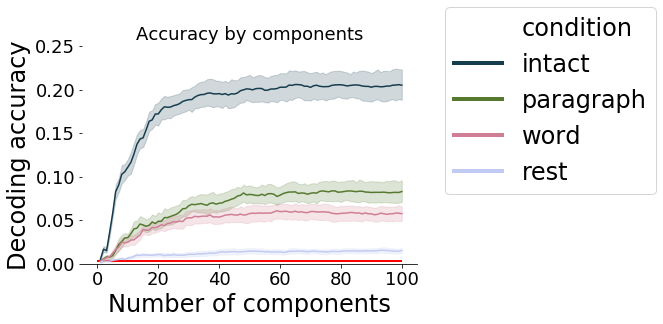

In [53]:
fig, ax = plt.subplots()
sns.lineplot(x="dims", y="accuracy",
             hue="condition",
             data=full_data, ax=ax, palette="cubehelix", hue_order=['intact', 'paragraph', 'word', 'rest'])
sns.despine(ax=ax, left=True)
ax.set_title('Accuracy by components')
ax.set_ylabel('Decoding accuracy',fontsize=24)
ax.set_xlabel('Number of components',fontsize=24)
ax.set_ylim(0, .25)
ax.hlines(y=1/300, xmin=0, xmax=100, linewidth=2, color='r')
#ax.legend(loc='center right', bbox_to_anchor=(1.6, 0.75), ncol=1)
l = ax.legend(loc='center right', bbox_to_anchor=(1.75, 0.75), ncol=1,fontsize=24)
for line in l.get_lines():
    line.set_linewidth(4.0)
fig.savefig(outfile, bbox_inches='tight')

In [54]:
resultsdir = '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_chunked/PCA/ndims_100'

In [55]:
conds =glob.glob(os.path.join(resultsdir, '*.csv'))

In [56]:
full_data = pd.DataFrame()
for c in conds:
    data = pd.read_csv(c)
    data['condition'] = os.path.basename(os.path.splitext(c)[0])

    if full_data.empty:
        full_data = data
    else:
        full_data = full_data.append(data)

In [57]:
full_data[full_data['condition']=='intact'].head()

KeyError: 'condition'

In [ ]:
for i in range(3):
    outfile = os.path.join(figdir, 'Accuracy_by_components_third_' + str(i) + '.pdf')
    fig, ax = plt.subplots()
    sns.lineplot(x="dims", y="accuracy",
                 hue="condition",
                 data=full_data[full_data['third']==i], ax=ax, palette="cubehelix", hue_order=['intact', 'paragraph', 'word', 'rest'])
    sns.despine(ax=ax, left=True)
    #ax.set_title('Accuracy by components for third: ' + str(i + 1))
    ax.set_ylabel('Decoding accuracy',fontsize=24)
    ax.set_xlabel('Number of components',fontsize=24)
    ax.set_ylim(0, .25)
    ax.hlines(y=1/100, xmin=0, xmax=100, linewidth=2, color='r')
    l = ax.legend(loc='center right', bbox_to_anchor=(1.75, 0.75), ncol=1,fontsize=24)
    for line in l.get_lines():
        line.set_linewidth(4.0)
    fig.savefig(outfile, bbox_inches='tight')